# Importar librerías

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np
import math

# Estadística y normalización
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder

# Visualización
import matplotlib.pyplot as plt #Importa la biblioteca matplot
import seaborn as sns # Importa la biblioteca seaborn


# Utilizamos el set_option para ver todas las columnas del fichero
pd.set_option('display.max_columns', None)

# Carga de datos

In [2]:
# Cargamos datos y leemos las primeras 5 filas
df_clean= pd.read_csv('../data/processed/dataset_estudiantes_clean.csv', sep=';')
df_clean.head()

,horas_estudio_semanal,nota_anterior,tasa_asistencia,horas_sueno,edad,nivel_dificultad,tiene_tutor,horario_estudio_preferido,estilo_aprendizaje,nota_final,aprobado
0,8.96,48.83,86.64,6.68,25,Facil,Si,Tarde,Lectura/Escritura,84.4,1
1,11.04,80.83,83.45,4.62,18,Dificil,No,Tarde,Desconocido,72.0,1
2,4.51,90.38,74.62,7.76,25,Facil,No,Mañana,Lectura/Escritura,80.0,1
3,6.65,81.88,82.85,8.59,23,Facil,No,Desconocido,Visual,78.2,1
4,1.00,66.25,54.54,6.67,21,Medio,No,Desconocido,Auditivo,66.0,1


### Separación del conjunto de datos

### Identificación de Outliers mediante Boxplot

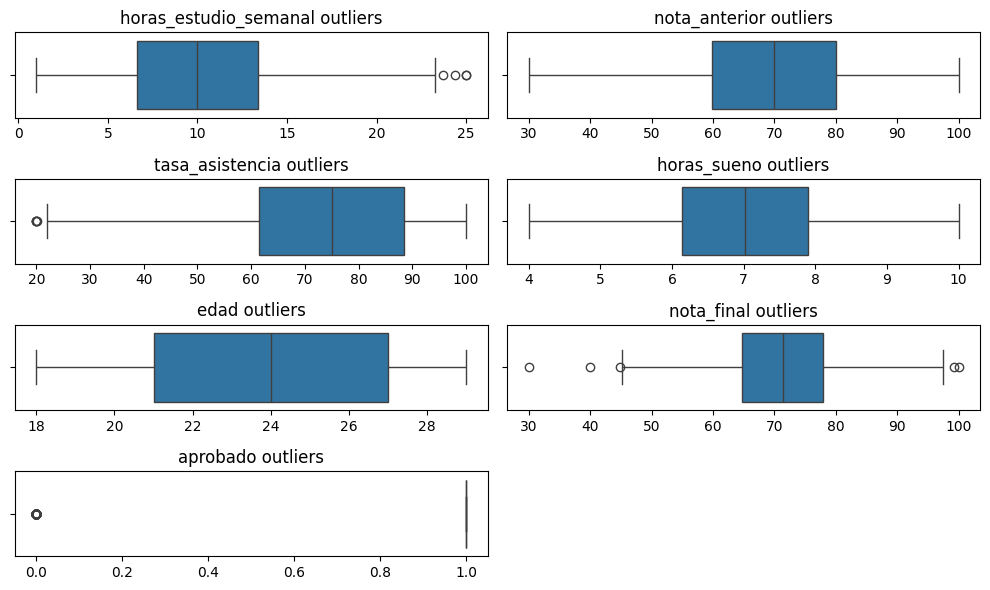

In [3]:
# Visualización de outliers de variables numéricas
df_num = df_clean.select_dtypes(include=np.number)
# Excluir la variable binaria
#df_num = df_num.drop('aprobado', axis=1, errors='ignore')
cols_num = df_num.columns

# Calculamos el número de gráficos y filas necesarias
n_plots = len(cols_num)
num_rows = math.ceil(n_plots / 2) # Se dividen en dos columnas

# Ajustar el tamaño dinámicamente de la figura
width = 5 * 2
height = 1.5 * num_rows
size = (width, height)

# Crear la estructura de subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=size)
axes = axes.flat # Convertir matriz de ejes a lista plana

# Crear un Boxplot para cada variable numérica
for i, col in enumerate(cols_num):
    sns.boxplot(
        x = col,
        data = df_num,
        ax = axes[i]
    )

    axes[i].set_title(f'{col} outliers')
    axes[i].set_xlabel('') # Eliminar la etiqueta del eje x para mayor claridad

# Eliminar el útlimo gráfico si sobra espacio vacío
if n_plots % 2 != 0: 
    fig.delaxes(axes[-1])

# Ajustamos el layout y mostrar la figura
plt.tight_layout()
plt.show()

### Detección de outliers mediante el método IQR 

In [4]:
# Diccionario para almacenar los outliers detectados en cada columna
outliers_dic_iqr = {}

# Iteración sobre cada columna numérica
for col in df_num.columns:
    # Calculo de cuartiles Q1 y Q3
    Q1 = df_num[col].quantile(0.25)
    Q3 = df_num[col].quantile(0.75)
    IQR = Q3 - Q1 # calcular el rango intercuartil

    # Definir los límites para detectar outliers (método de la valla)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar los outliers en la columna actual
    outliers = df_num[(df_num[col] < lower_bound) | (df_num[col] > upper_bound)]

    # Almacena el resultado en el diccionario
    outliers_dic_iqr[col] = outliers

In [5]:
outliers_dic_iqr['horas_estudio_semanal']

,horas_estudio_semanal,nota_anterior,tasa_asistencia,horas_sueno,edad,nota_final,aprobado
384,24.39,94.96,79.84,7.48,28,71.5,1
594,25.00,73.32,82.74,8.10,22,77.7,1
695,23.74,76.05,58.40,6.55,24,72.5,1
945,25.00,90.87,100.00,7.90,23,86.7,1


In [6]:
outliers_dic_iqr['tasa_asistencia']

,horas_estudio_semanal,nota_anterior,tasa_asistencia,horas_sueno,edad,nota_final,aprobado
603,10.21,60.22,20.00,9.57,19,65.7,1
630,9.07,60.13,20.00,8.06,29,64.5,1
744,6.21,76.01,20.05,4.81,23,65.0,1
974,1.00,30.22,20.00,4.34,23,50.8,0


In [7]:
outliers_dic_iqr['nota_final']

,horas_estudio_semanal,nota_anterior,tasa_asistencia,horas_sueno,edad,nota_final,aprobado
323,1.00,37.05,24.76,5.72,18,40.0,0
579,1.00,30.00,64.24,7.97,29,30.0,0
606,16.61,100.00,100.00,8.75,27,99.2,1
822,2.43,75.36,84.84,7.16,27,44.9,0
927,14.83,100.00,72.81,7.65,18,100.0,1


### Detección de outliers mediante el método Z-score

In [8]:
# Diccionario para almacenar los outliers de z-score
outliers_dic_z = {}

# Iteración sobre cada columna numérica
for col in df_num.columns:

    # Filtrar los valores utilizando Z > 3
    outliers = df_num[col][np.abs(zscore(df_num[col])) > 3]

    # Guardar solo los valores, reseteando el índice
    outliers_dic_z[col] = outliers.reset_index(drop=True)

# Concatenar todos los valores en un DataFrame limpio
outliers_z_df = pd.DataFrame({
    'columna': np.repeat(list(outliers_dic_z.keys()), [len(v) for v in outliers_dic_z.values()]),
    'valor': pd.concat(outliers_dic_z.values(), ignore_index=True)
})

print(outliers_z_df)

                 columna  valor
0  horas_estudio_semanal   25.0
1  horas_estudio_semanal   25.0
2             nota_final   40.0
3             nota_final   30.0


# Regresión

#### La variable objetivo es <span style='color: #FFFF99;'>nota_final</span>

In [9]:
# Hacemos una copia del dataframe
df_reg = df_clean.copy()

# Selecionamos la variable objetivo
tv = 'nota_final'

### Codificación

##### 1. OrdinalEncoder

In [10]:
# OrdinalEncoder (para variables con orden)
ord_encoder = OrdinalEncoder(categories=[['Facil','Medio','Dificil'],  # orden para nivel_dificultad
                                         ['No','Si']])                 # orden para tiene_tutor

df_reg[['nivel_dificultad','tiene_tutor']] = ord_encoder.fit_transform(df_reg[['nivel_dificultad','tiene_tutor']])

df_reg['nivel_dificultad'] = df_reg['nivel_dificultad'] + 1 # Para que empiece en 1

In [11]:
df_reg

,horas_estudio_semanal,nota_anterior,tasa_asistencia,horas_sueno,edad,nivel_dificultad,tiene_tutor,horario_estudio_preferido,estilo_aprendizaje,nota_final,aprobado
0,8.96,48.83,86.64,6.68,25,1.0,1.0,Tarde,Lectura/Escritura,84.4,1
1,11.04,80.83,83.45,4.62,18,3.0,0.0,Tarde,Desconocido,72.0,1
2,4.51,90.38,74.62,7.76,25,1.0,0.0,Mañana,Lectura/Escritura,80.0,1
3,6.65,81.88,82.85,8.59,23,1.0,0.0,Desconocido,Visual,78.2,1
4,1.00,66.25,54.54,6.67,21,2.0,0.0,Desconocido,Auditivo,66.0,1
...,...,...,...,...,...,...,...,...,...,...,...
995,12.82,79.45,87.06,5.58,22,2.0,1.0,Noche,Lectura/Escritura,78.9,1
996,15.20,87.25,90.16,6.06,24,2.0,1.0,Mañana,Auditivo,73.6,1
997,8.16,53.32,61.53,6.56,29,1.0,0.0,Noche,Lectura/Escritura,65.0,1
998,18.58,88.31,96.33,6.69,21,2.0,1.0,Noche,Kinestésico,73.8,1


##### 2. OneHotEncoder

In [12]:
# OneHotEncoder (para variables nominales)
OneHot_code = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')  

onehot_cols = ['horario_estudio_preferido','estilo_aprendizaje']
onehot_encoded = OneHot_code.fit_transform(df_reg[onehot_cols])

# Tomamos las categorías del encoder y generamos nombres legibles
col_names = []
for i, col in enumerate(onehot_cols):
    categories = OneHot_code.categories_[i]
    for cat in categories:
        col_clean = cat.replace(' ', '_')  # reemplaza espacios por guion bajo
        col_names.append(f'{col.split('_')[0]}_{col_clean.lower()}')  # ejemplo: horario_tarde, estilo_visual
encoded_df = pd.DataFrame(onehot_encoded, columns=col_names, index=df_reg.index)

# Combinar el ordinalEncoder con el OneHotEncoder
df_reg.drop(columns=onehot_cols, inplace=True)  # modifica df_reg directamente
df_reg = pd.concat([df_reg, encoded_df], axis=1)


In [13]:
df_reg.head()

,horas_estudio_semanal,nota_anterior,tasa_asistencia,horas_sueno,edad,nivel_dificultad,tiene_tutor,nota_final,aprobado,horario_desconocido,horario_mañana,horario_noche,horario_tarde,estilo_auditivo,estilo_desconocido,estilo_kinestésico,estilo_lectura/escritura,estilo_visual
0,8.96,48.83,86.64,6.68,25,1.0,1.0,84.4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,11.04,80.83,83.45,4.62,18,3.0,0.0,72.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,4.51,90.38,74.62,7.76,25,1.0,0.0,80.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6.65,81.88,82.85,8.59,23,1.0,0.0,78.2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.00,66.25,54.54,6.67,21,2.0,0.0,66.0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [14]:
# Hacemos una copia del resultado para el modelo de clasificacion antes de realizar el escalado
df_cla = df_reg.copy()

### Escalado

##### MinMaxScaler

In [15]:
scaler = MinMaxScaler()
df_reg[df_reg.drop(columns=[tv]).columns] = scaler.fit_transform(df_reg.drop(columns=[tv]))

# Clasificación

In [16]:
# Mantenemos el resultado anterior del preprocesamiento pero con la variable objetivo distinta
tv_cla= 'aprobado'
df_cla[df_cla.drop(columns=[tv_cla]).columns] = scaler.fit_transform(df_cla.drop(columns=[tv_cla]))

### Guardar Dfs preprocesados

In [19]:
# Exportamos el fichero de regresión después de su limpieza y análisis a csv
df_reg.to_csv('../data/processed/df_regresion.csv', sep=';', decimal='.', index=False) 

# Exportamos el fichero de clasificación después de su limpieza y análisis a csv
df_cla.to_csv('../data/processed/df_clasificacion.csv', sep=';', decimal='.', index=False) 